In [1]:
import numpy as np
import pandas as pd 
import json
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt 

In [2]:
import joblib

In [3]:
df = pd.read_csv("../data/processed/transactions_features.csv")

with open("../models/model_features_v1.json") as f:
    FEATURES = json.load(f)["features"]

scaler = joblib.load("../models/standard_scaler_v1.pkl")

X = df[FEATURES]
X_scaled = scaler.transform(X)

print("Data shape:", X_scaled.shape)

Data shape: (100000, 9)


In [4]:
df_normal = df[df["is_fraud"] == 0]
X_normal = scaler.transform(df_normal[FEATURES])

print("Normal samples:", X_normal.shape)
# train only on normal models => One-Class SVM learns what normal looks like. 
# Anything that deviates from normal is considered an anomaly. 

Normal samples: (98962, 9)


In [5]:
ocsvm = OneClassSVM(
    kernel="rbf",
    nu=0.01,       # allow ~1% anomalies
    gamma="scale" # safe default
)

ocsvm.fit(X_normal)

,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm.If none is given, 'rbf' will be used. If a callable is given it isused to precompute the kernel matrix.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"nu nu: float, default=0.5An upper bound on the fraction of trainingerrors and a lower bound of the fraction of supportvectors. Should be in the interval (0, 1]. By default 0.5will be taken.",0.01
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False
,"max_iter max_iter: int, default=-1Hard limit on iterations within solver, or -1 for no limit.",-1


In [6]:
svm_scores = ocsvm.decision_function(X_scaled)

df["svm_score"] = svm_scores

#Positive → inside boundary
# Negative → outside boundary (anomalous)

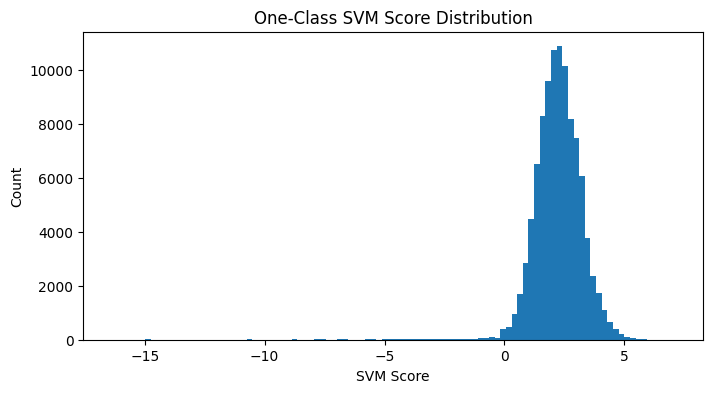

In [7]:
plt.figure(figsize=(8, 4))
plt.hist(svm_scores, bins=100)
plt.title("One-Class SVM Score Distribution")
plt.xlabel("SVM Score")
plt.ylabel("Count")
plt.show()


In [8]:
svm_threshold = np.percentile(svm_scores, 1)
svm_threshold

np.float64(-0.00011051983494503758)

In [9]:
df["svm_flag"] = df["svm_score"] < svm_threshold

print("SVM anomaly rate:", df["svm_flag"].mean())

SVM anomaly rate: 0.01


In [10]:
df.sort_values("svm_score").head(10)[
    FEATURES + ["svm_score"]
]

,amount_dev_log,avg_amount_24h,txn_count_1h,txn_count_24h,time_since_last_txn_sec,distance_from_home,travel_speed_kmh,hour_sin,hour_cos,svm_score
57837,-7.090104,2481.652000,4.0,5.0,2.463696e+02,1169.73,17160.017133,-0.707107,-7.071068e-01,-16.391193
21340,0.000000,599.950000,1.0,1.0,6.732395e+06,1735.47,0.930609,0.000000,1.000000e+00,-16.342018
20463,4.349719,324.093333,4.0,12.0,1.255821e+03,1746.11,657.498325,1.000000,6.123234e-17,-15.899232
96327,7.032596,2417.382500,3.0,12.0,1.822783e+02,6.71,10069.050896,0.866025,-5.000000e-01,-15.697347
53694,3.808620,217.381818,3.0,11.0,2.446216e+02,1005.21,14686.958881,0.000000,1.000000e+00,-15.453062
94717,5.756335,612.612500,2.0,4.0,4.243125e+02,1739.31,14771.118228,-0.707107,7.071068e-01,-15.142126
20462,4.135923,317.142727,3.0,11.0,2.230971e+02,1964.01,20000.000000,1.000000,6.123234e-17,-14.997396
39771,2.852617,472.946923,2.0,13.0,1.871659e+02,757.34,14492.923054,1.000000,6.123234e-17,-14.967386
53093,0.000000,3994.350000,1.0,1.0,3.783126e+06,11.98,0.804820,-0.866025,5.000000e-01,-14.960846
13389,0.000000,4105.330000,1.0,1.0,1.925335e+06,5.94,0.009281,-0.500000,-8.660254e-01,-14.910706


In [11]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# Ground truth (ONLY for evaluation)
y_true = df["is_fraud"]

# Binary predictions from threshold
y_pred = df["svm_flag"].astype(int)

# Metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# ROC-AUC uses scores, not flags
roc_auc = roc_auc_score(y_true, -df["svm_score"])
# NOTE: negative because lower score = more anomalous

print("One-Class SVM Metrics")
print("---------------------")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

One-Class SVM Metrics
---------------------
Precision: 0.0420
Recall:    0.0405
F1-score:  0.0412
ROC-AUC:   0.5226

Confusion Matrix:
[[98004   958]
 [  996    42]]


In [12]:
import joblib

joblib.dump(ocsvm, "../models/one_class_svm_v1.pkl")

with open("../models/thresholds_v1.json", "r") as f:
    thresholds = json.load(f)

thresholds["one_class_svm"] = {
    "threshold_type": "percentile",
    "percentile": 1,
    "threshold_value": float(svm_threshold)
}

with open("../models/thresholds_v1.json", "w") as f:
    json.dump(thresholds, f, indent=2)


SVM plot: majority positive, long negative tail  
Anomaly rate: ~1%  
Observations: One-Class SVM successfully learns a global boundary of normal behavior, 
with most transactions lying inside the boundary (positive scores) and a small fraction 
falling outside (negative tail). However, ROC-AUC is close to random, indicating that 
fraud transactions are not well-separated by a single global boundary. This suggests 
high behavioral heterogeneity among legitimate users and fraud patterns that often 
overlap with normal behavior. Therefore, One-Class SVM is retained as a complementary 
signal rather than a primary decision model.


In [14]:
# comparision of model with different anomaly rates

ANOMALY_RATES = [0.005, 0.01, 0.02]

results = []
y_true = df["is_fraud"].values

for rate in ANOMALY_RATES:
    threshold = np.percentile(svm_scores, rate * 100)
    y_pred = (svm_scores < threshold).astype(int)

    results.append({
        "model": "One-Class SVM",
        "anomaly_rate": rate,
        "threshold": threshold,
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, -svm_scores)
    })

df_ocsvm_results = pd.DataFrame(results)
df_ocsvm_results


,model,anomaly_rate,threshold,precision,recall,f1,roc_auc
0,One-Class SVM,0.005,-1.489635,0.0560,0.026975,0.036411,0.522647
1,One-Class SVM,0.010,-0.000111,0.0420,0.040462,0.041217,0.522647
2,One-Class SVM,0.020,0.386543,0.0265,0.051060,0.034891,0.522647


In [16]:
df_ocsvm_results.to_csv(
    "../reports/ocsvm_results.csv",
    index=False
)

print("Saved: reports/ocsvm_results.csv")


Saved: reports/ocsvm_results.csv
